# US Census Data 1790-2000

Based on EdX [Introduction to Differential Equations](https://courses.edx.org/courses/course-v1%3ABUx%2BMath226.1x%2B1T2016/) and [this notes](http://www.math.northwestern.edu/~mlerma/courses/math214-2-04f/notes/c2-logist.pdf)

Given a population $p$ at a certain time, assumes the relative growth rate decreases linearly with $p$. The relative growth rate is defined as $\delta p / p = \frac{dp}{dt} \frac{1}{p}$


<img src="imgs/difflr.jpg"/>


this is, 

$$\frac{dp}{dt} = k p (1-\frac{p}{n})$$


meaning that $\frac{1}{p}\frac{dp}{dt}$ is linear in $p$

## 1. Estimate $k$ and $N$ from data

### A. Load and show data

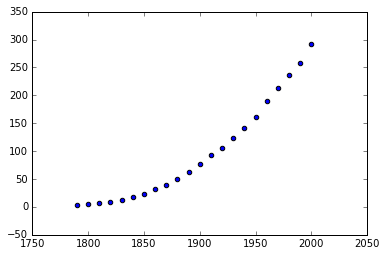

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

uscensus = pd.read_csv("data/uspop.csv")
uscensus["population"] = uscensus["population"]/1e6
plt.scatter(uscensus["year"], uscensus["population"])

In [2]:
uscensus.head()

,year,population
0,1790,3.929214
1,1800,5.308483
2,1810,7.239881
3,1820,9.638453
4,1830,12.860702


### B. Estimate $k$ and $N$ from data

The population of a given year is $P_{year}$. For instance $P_{1790}=3.93$, $P_{1800}=5.30$, etc.

For any given year, we can estimate the growth rate using the data from the previous and the next year.

The **growth rate** of any given year as estimated by the data is:

$$G_{y} = \frac{P_{y[+1]}-P_{y[-1]}}{(y[+1]-y[-1])}$$

where $y[-1]$ and $y[+1]$ are the previous and next year to $y$ for which we have data.

The **relative growth rate** of any given year is estimated by:

$$R_y = \frac{G_y}{P_y}$$

In [3]:
pop = uscensus["population"].as_matrix()
uscensus["growth"] = [None]+list((pop[2:]-pop[:-2])/20)+[None]
uscensus["relgrowth"] = uscensus["growth"]/uscensus["population"]
uscensus.head()

,year,population,growth,relgrowth
0,1790,3.929214,NaN,NaN
1,1800,5.308483,0.165533,0.031183
2,1810,7.239881,0.216499,0.029904
3,1820,9.638453,0.281041,0.029158
4,1830,12.860702,0.371245,0.028867


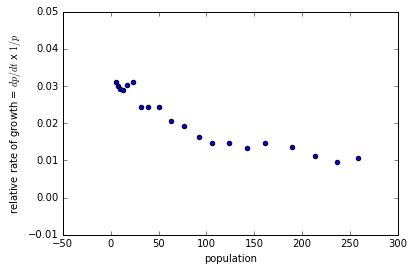

In [4]:
plt.scatter(uscensus["population"], uscensus["relgrowth"])
plt.xlabel("population")
plt.ylabel("relative rate of growth = $dp/dt$ x $1/p$")

use a linear regression to fit a line to the data and get $k$, and $N$ which are the intercept points with each axis. recall from above that $m=-k/N$

In [5]:
X = uscensus["population"].as_matrix()[1:-1].reshape((-1,1))
y = uscensus["relgrowth"].as_matrix()[1:-1]

from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X,y)
m = lr.coef_ [0]
k_val  = lr.intercept_
n_val  = -k_val/m
print "N", n_val
print "k", k_val

N 329.688289793
k 0.0286629770895


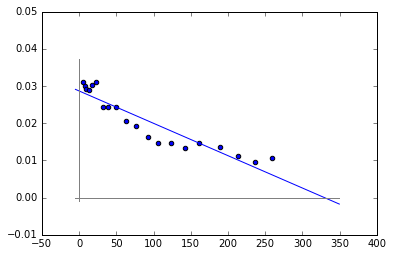

In [6]:
plt.scatter(uscensus["population"], uscensus["relgrowth"])
x = np.linspace(np.min(-5), n_val+20, 100)
plt.plot(x, k_val+m*x)
plt.plot(np.linspace(-5,n_val+20,100), np.zeros(100), color="gray")
plt.plot(np.zeros(100), np.linspace(-.001,k_val*1.3,100), color="gray")

## 2. Solve the ODE

### A. Setup and solve the ODE

In [7]:
from sympy import *
init_printing(use_latex=True)
t, C1, C2, A, p_init = symbols("t C1 C2 A p_{init}")
k, n = symbols("k n", positive=True)
P = symbols('P', cls=Function)
eq = simplify(k*P(t)*(1-P(t)/n))
diffeq = Eq(P(t).diff(t) , eq)
diffeq


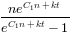

In [8]:
pt = dsolve(diffeq, P(t))
pt.rhs

Check the solution is correct

In [9]:
simplify(eq.subs(P(t), pt.rhs) - diff(pt.rhs, t))

### B. Try to obtain params

now, if we try to solve for $C_1$ given the initial conditions, $P(0)=3.93$ and $k$ and $n$ estimated from the data, the solver fails (either hangs or takes a long time to yield an error).

initial conditions: P(0)=3.929
estimated params:   k=0.0287 n=329.69


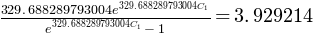

In [13]:
p0 = uscensus.population[0]
t0 = 0

print "initial conditions: P(0)=%.3f"%p0
print "estimated params:   k=%.4f"%k_val, "n=%6.2f"%n_val

param_eq = Eq(pt.rhs.subs({n:n_val, k: k_val, t: t0}), p0)
param_eq

In [ ]:
solve(param_eq)

### C. Substitue and obtain ODE params

However, if we perform the substitution:
    
$$e^{C_1n} = -\frac{1}{A}$$

we really help the solver.

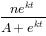

In [15]:
pt2 = simplify(pt.rhs.subs({exp(C1*n):-1/A}))
pt2

In [16]:
sol = solve(pt2.subs({n:n_val, k: k_val, t: t0})-p0)
A_val = sol[0]
A_val

we check anyhow that the new expression also complies with the differential equaltion

In [17]:
simplify(eq.subs(P(t), pt2) - diff(pt2, t))

### C. Plot prediction

and finally we obtain an evaluable function and plot it along side the data to get a sense of how well it models it

In [18]:
fpa = lambda x: pt2.subs({n: n_val, k: k_val, t: x, A: A_val})
fpa = np.vectorize(fpa)

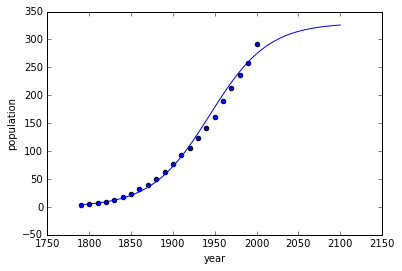

In [19]:
plt.scatter(uscensus["year"], uscensus["population"])
x = np.linspace(1790,2100,100)
plt.plot(x, fpa(x-1790))
plt.xlabel("year")
plt.ylabel("population")

### D. Different functions for different initial conditions

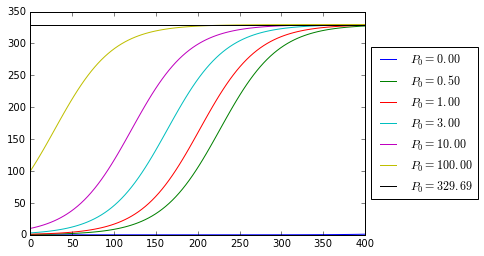

In [20]:
t0=0
for p_init in [0.00001,0.5,1,3,10,100,n_val]:
    sol = solve(pt2.subs({n:n_val, k: k_val, t: t0})-p_init)
    A_v = sol[0]
    f = np.vectorize(lambda x: pt2.subs({n: n_val, k: k_val, t: x, A: A_v}))
    x = np.linspace(0,400,100)
    plt.plot(x, f(x), label="$P_0=%.2f$"%p_init)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
